In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import Sequential, Model

In [ ]:
import tensorflow_datasets as tfds
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Text(0.5, 1.0, '5')

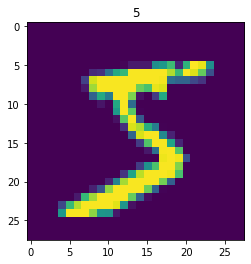

In [ ]:
#print(img)
import matplotlib.pyplot as plt
plt.imshow(X_train[0])
plt.title(y_train[0])

In [ ]:
img_A_inp = Input((28, 28), name='img_A_inp')#Image 1
img_B_inp = Input((28, 28), name='img_B_inp')#Image 2
model = Sequential([Reshape((28, 28, 1)),
                  Sequential([Conv2D(64,3,1),BatchNormalization(),ReLU()]),
                  Sequential([Conv2D(128,3,1),BatchNormalization(),ReLU()]),
                  Sequential([Conv2D(256,3,1),BatchNormalization(),ReLU()]),
                  Sequential([Conv2D(512,3,1),BatchNormalization(),ReLU()]),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])
#after CNN comes feature vectors
feature_vector_A = model(img_A_inp)
feature_vector_B = model(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

modell = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

modell.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_14 (Sequential)     (None, 64)           1586496     ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128)          0           ['sequential_14[0][0]',    

In [ ]:
random_indices = np.random.choice(X_train.shape[0], 300, replace=False)
X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]
X_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

In [ ]:
len(X_train_sample) ** 2

90000

In [ ]:
import itertools
def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []
  tuples = [(x1, y1) for x1, y1 in zip(X, y)]
  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]
    new_label = int(label_A == label_B)
    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)
  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)
  return X_pairs, y_pairs

In [ ]:
make_paired_dataset(X_train_sample, y_train_sample)

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0

In [ ]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)
X_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [ ]:
random_indices = np.random.choice(X_test.shape[0], 150, replace=False)
X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]
X_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [ ]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)
X_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [ ]:
modell.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [ ]:
modell.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :], 
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=5,
          batch_size=32,
          callbacks=[es])

Epoch 1/5
2813/2813 [==============================] - 129s 45ms/step - loss: 0.1871 - accuracy: 0.9303 - val_loss: 0.2307 - val_accuracy: 0.9190
Epoch 2/5
2813/2813 [==============================] - 125s 45ms/step - loss: 0.0405 - accuracy: 0.9844 - val_loss: 0.3502 - val_accuracy: 0.9205
Epoch 3/5
2813/2813 [==============================] - 125s 44ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.3107 - val_accuracy: 0.9354
Epoch 4/5
2813/2813 [==============================] - 125s 44ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.2830 - val_accuracy: 0.9460


In [ ]:
img_A, img_B = X_test[0], X_test[17]
label_A, label_B = y_test[0], y_test[17]

label_A, label_B

(7, 7)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=28)
plt.imshow(img_A)

KeyboardInterrupt: ignored

<Figure size 168x112 with 0 Axes>

In [ ]:
plt.figure(dpi=28)
plt.imshow(img_B)

In [ ]:
modell.predict([img_A.reshape((1, 28, 28)), 
               img_B.reshape((1, 28, 28))]).flatten()[0] > 0.5